In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import shapely.geometry as shg
from IPython.display import HTML

In [127]:
shps = gpd.read_file('./data/landkreise_risklayer.geojson')
shps = shps.rename(columns={'type': 'art', 'ags': 'AGS'})
shps['AGS'] = shps['AGS'].astype(np.int64)
lks = shps[shps.art == 'landkreis']
lks

,art,name,partof,population,AGS,geometry
16,landkreis,Halle,Sachsen-Anhalt,239257,15002,"POLYGON ((12.00471 51.53966, 12.04427 51.49398..."
17,landkreis,Fürth (Stadt),Bayern,127748,9563,"POLYGON ((10.98974 49.43607, 10.96199 49.45750..."
18,landkreis,Neumünster,Schleswig-Holstein,79487,1004,"POLYGON ((10.03454 54.12915, 10.01577 54.07925..."
19,landkreis,Eisenach,Thüringen,42370,16056,"POLYGON ((10.18383 50.99842, 10.20182 51.01285..."
20,landkreis,Saale-Orla-Kreis,Thüringen,80868,16075,"POLYGON ((11.86614 50.78823, 11.90047 50.78606..."
...,...,...,...,...,...,...
412,landkreis,Eifelkreis Bitburg-Prüm,Rheinland-Pfalz,98561,7232,"POLYGON ((6.40389 50.32327, 6.42663 50.32270, ..."
413,landkreis,Görlitz,Sachsen,254894,14626,"POLYGON ((14.49107 51.04324, 14.47569 51.07406..."
414,landkreis,Tuttlingen,Baden-Württemberg,140152,8327,"POLYGON ((8.95350 48.10709, 8.99629 48.07063, ..."
415,landkreis,Waldshut,Baden-Württemberg,170619,8337,"POLYGON ((8.43865 47.85352, 8.50599 47.82931, ..."


In [128]:
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\lang_m13\\Downloads\\ffmpeg-20200403-52523b6-win64-static\\bin\\ffmpeg.exe'

In [129]:
rootgroupFebr = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
rootgroupMarch = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
rootgroupApril = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")

In [130]:
Tfeb, X, Y = rootgroupFebr['tcno2'].shape
Tmarch, _, _ = rootgroupMarch['tcno2'].shape
Tapril, _, _ = rootgroupApril['tcno2'].shape
Tmeassure = 21
Tdelta = 14

#beforeVals = np.concatenate((rootgroupFebr['tcno2'][-(Tdelta - Tmeassure):], rootgroupMarch['tcno2'][:Tmeassure]))
beforeVals = rootgroupMarch['tcno2'][(Tmeassure - Tdelta):Tmeassure]
afterVals = np.concatenate((rootgroupMarch['tcno2'][Tmeassure:], rootgroupApril['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

In [131]:
beforeVals.shape

(14, 81, 89)

In [132]:
afterVals.shape

(14, 81, 89)

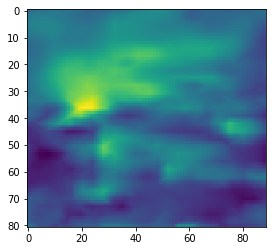

In [133]:
beforeSum = np.sum(beforeVals, axis=0)
afterSum = np.sum(afterVals, axis=0)
plt.imshow(beforeSum - afterSum)

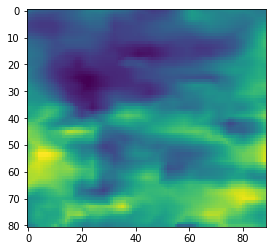

In [134]:
plt.imshow(afterSum / beforeSum)

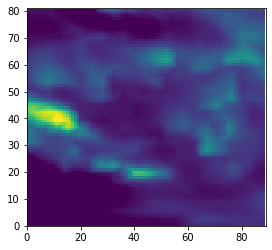

In [135]:
def video(data):
    T, X, Y = data.shape

    fig = plt.figure()
    ax = plt.axes(xlim=(0, Y), ylim=(0, X))
    img = plt.imshow(data[0], animated=True)

    def update(i):
        img.set_data(data[i])
        return [img]
    
    ani = FuncAnimation(fig, update, range(T), blit=True)
    return ani

a = video(rootgroupMarch['tcno2'])
a.save('./output/test_anim.mp4')

In [173]:
lks['before'] = pd.Series([0 for x in range(len(lks.index))])
lks['after'] = pd.Series([0 for x in range(len(lks.index))])
X, Y = beforeSum.shape

for x in range(X):
    for y in range(Y):
        lon = rootgroupMarch['longitude'][y]
        lat = rootgroupMarch['latitude'][x]
        pt = shg.Point(lon, lat)   # shapely uses (longitude, latitude)
        for i in lks.index:
            lk = lks.loc[i]
            if lk.geometry.contains(pt):
                lks.loc[i, 'before'] += beforeSum[x, y]
                lks.loc[i, 'after'] += afterSum[x, y]
                break



In [174]:
lks['diff'] = lks['after'] - lks['before']
lks['diffPerc'] = lks['after'] / lks['before']
lks.head()

,art,name,partof,population,AGS,geometry,before,after,diff,diffPerc
16,landkreis,Halle,Sachsen-Anhalt,239257,15002,"POLYGON ((12.00471 51.53966, 12.04427 51.49398...",0.000249,0.000200,-0.000049,0.803649
17,landkreis,Fürth (Stadt),Bayern,127748,9563,"POLYGON ((10.98974 49.43607, 10.96199 49.45750...",0.000115,0.000093,-0.000022,0.804842
18,landkreis,Neumünster,Schleswig-Holstein,79487,1004,"POLYGON ((10.03454 54.12915, 10.01577 54.07925...",0.000111,0.000072,-0.000039,0.652320
19,landkreis,Eisenach,Thüringen,42370,16056,"POLYGON ((10.18383 50.99842, 10.20182 51.01285...",0.000224,0.000208,-0.000016,0.929734
20,landkreis,Saale-Orla-Kreis,Thüringen,80868,16075,"POLYGON ((11.86614 50.78823, 11.90047 50.78606...",0.001009,0.000939,-0.000070,0.930588


In [175]:
lks.to_file("./data/landkreise_no2_14d.json", driver="GeoJSON", encoding="utf-8")

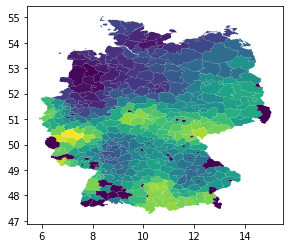

In [176]:
lks.plot(column='diffPerc')

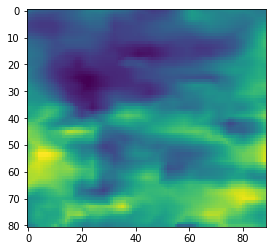

In [177]:
plt.imshow(afterSum / beforeSum)

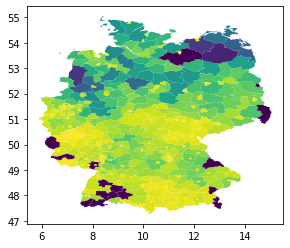

In [178]:
lks.plot(column='diff')

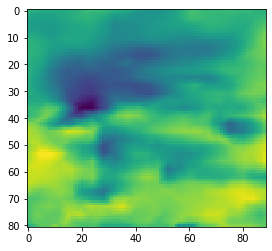

In [179]:
plt.imshow(afterSum - beforeSum)

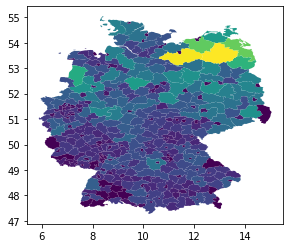

In [180]:
lks.plot(column='before')

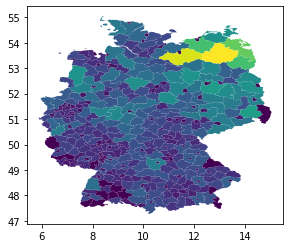

In [181]:

lks.plot(column='after')